# Housing Data Project - Dealing with Nulls & Categorical Encodings
This dataset is [here](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv("house-prices/train.csv", index_col="Id")
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [127]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [124]:
# a peak at the target distribution
# train["SalePrice"].plot(kind="hist", bins=20, grid=True);

# Dealing with NULL data

## Strategy 1 - Drop Nulls
Throw data away. We can simply drop all NULL values... or drop a row / column if there are too many NULL values.
- This is a bad idea, we might have 99% good info (enough to make a good decision) and don't want to abandon that observation. - We could drop rows or columns with > some % null values.
  - This can make sense, especially for a row with nearly no information.
  - For a column, we need to be careful, sometimes rare events have a ton of information.
  - e.g. imagine a driving risk prediction with a DUI column. Few drivers will have a DUI so the data may be mostly null; however it will highly impact the risk for those drivers where DUI is present.
 
**This is easy to code.. but ultimately not a great idea**

In [117]:
# drop all null values
train.dropna(how="any") # drop all rows with a null value (axis=0 by default)
train.dropna(how="any", axis=1) # drop all columns with a null value

# drop based on a threshold
thresh = .1
train.dropna(thresh=int(thresh * train.shape[0])), axis=0) # drop all rows with > 10% null data
train.dropna(thresh=int(thresh * train.shape[1])), axis=1) # drop all columns with > 10% null data

## Strategy 2 - Impute (fill) NULLS
This involves some "guess work", often we make our guesses very simple. For numeric data we guess the average, for categorical data we guess the most frequently occuring category.

- Note that the implementation is different for numerical & categorical data
- e.g. mean / median vs. top frequency

**A note of caution**
The issue with this approach is that sometimes NULL data has information, i.e. you can learn something by the fact data is not present. If we impute (i.e. fill) in the nulls, then we may be throwing away information (by over-writing it).
- we can improve on this by 1st capturing NULL data as a binary indicator column e.g. `col_a` -> `col_a_na`
  - we create a new column `col_a_na` which has a 1 when `col_a` has a null and a 0 otherwise
  - *then* we can impute the NULL value in the column
  - essentially we have lost no information, and if NULL data contains information the model can use it... otherwise we can ignore the `col_a_na` column after reviewing the model

#### Simply filling in values

In [119]:
# impute the mean for numeric nulls
num_col = train.select_dtypes(include=[np.number]).columns
# it is a BEST practice to have this lookup to apply it to future data
num_lookup = train[num_col].mean().to_dict()
train.fillna(value=num_lookup, inplace=True)

# capture the top frequency for categorical columns (mode)
cat_cols = train.select_dtypes(exclude=[np.number]).columns
# this lookup is a dict of the key=column name value = column mode (most freq value)
# it is a BEST practice to have this lookup to apply it to future data
cat_lookup = train[cat_cols].mode().T.to_dict()[0]
train.fillna(value=cat_lookup, inplace=True)

# train.info()

#### More advanced - Create NA column, then fill in

In [ ]:
# create binary indicators for all columns with NULL values

# a BEST practice is to capture the newly created na columns - for future datasets
na_cols = []
for col in train.columns:
    nan = train[col].isna() # array of nan values (bool)
    if nan.sum() > 0:
        name = f"{col}_na"
        train[name] = nan.astype(int)
        na_cols.append(name)


# then we can run the same code as above! doing this 1st we lose zero information

## Strategy 3 - Modeling
This is far too advanced for now... but the concept is worth a couple words
- imputed values above are highly naieve
- simple models for "guessing" the values are potentially MUCH more effective
- e.g. we could create a simple rule for filling in a null value
- but building models to prepare for building models is way beyond the scope of what we're doing here
- just know that we *could* do this

# Dealing with Categorical Data

### Strategy 1. Drop all Non-Numeric Columns
This is easy to do... but throws information away (which is bad)
```
44676.07 RMSE
0.69 r2
```

In [82]:
# find all numeric columns
# NOTE the function returns the df of the selected dtypes
train = train.select_dtypes(include=[np.number])

# are there still null values?  YES - there are still NULLS
# train.info()

### Strategy 2. Encode All Categories as One Hot Encoding
This is a decent strategy for "unordered" categories - but its not great for 'ordered' categories (e.g. S, M, L)


The overall scores improved (adding in categorical data, we decreased the averager amount of error by approx $800
```
43877.06 RMSE
0.70 r2
```

In [69]:
# select all the categorical columns
cat_cols = train.select_dtypes(include=[pd.Categorical]).columns

# NOTE we can deal with NULL data here! create a null column
train = pd.get_dummies(train, columns=cat_cols, dummy_na=True, dtype=int)

# Build a Model

In [128]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

### Stratify Split Train into Train & Tune

In [70]:
TARGET = "SalePrice"

# to support stratification - bin the continuous variable
cuts, bins = pd.qcut(train[TARGET], q=5, retbins=True, labels=list(range(5)))
train['bins'] = cuts

# train['bins'].value_counts(normalize=True)
x_train, x_tune = train_test_split(train, test_size=.25, stratify=train['bins'], random_state=0)

x_train.drop(columns=["bins"], inplace=True)
x_tune.drop(columns=["bins"], inplace=True)

y_train = x_train.pop(TARGET)
y_tune = x_tune.pop(TARGET)

In [71]:
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0).fit(x_train, y_train)

# Evaluate the Model

In [72]:
from sklearn.metrics import root_mean_squared_error, r2_score

In [73]:
y_true = y_tune
y_pred = rf.predict(x_tune)

rmse = root_mean_squared_error(y_true=y_true, y_pred=y_pred)
r2 = r2_score(y_true=y_true, y_pred=y_pred)

print(f"{rmse:.2f} RMSE")
print(f"{r2:.2f} r2")

43877.06 RMSE
0.70 r2


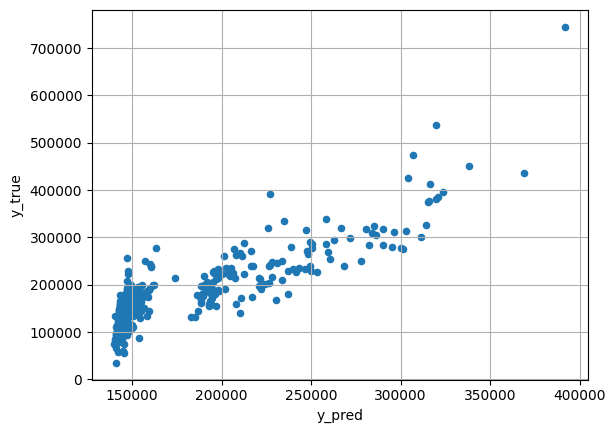

In [74]:
# NOTE a MUCH BETTER PLOT would force x and y to have the same scaled axis (i.e. ticks are 1:1)
pd.DataFrame({"y_true": y_true, "y_pred": y_pred}).plot(kind="scatter", x="y_pred", y="y_true", grid=True);